In [826]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture

# Precomputed clusters:

In [493]:
cluster_df = pd.read_csv('clusters.csv', sep=';')
cluster_stats = cluster_df.groupby('Cluster_ID').agg({'Mean_Duration': 'mean', 'N_Events': 'count' })

In [454]:
def compute_interarrival_time(record):
    return record['Mean_Duration'] / record['N_Events']

cluster_stats['Interarrival_time'] = cluster_stats.apply(compute_interarrival_time, axis=1)

In [455]:
cluster_stats.columns = ['Total_Duration', 'N_Events', 'Interarrival_time']

In [456]:
cluster_stats['N_Events'].describe()

count    249.000000
mean       7.433735
std       12.392629
min        2.000000
25%        2.000000
50%        3.000000
75%        6.000000
max       86.000000
Name: N_Events, dtype: float64

In [457]:
cluster_stats['Total_Duration'].describe()

count    249.000000
mean       3.566506
std        3.881389
min        0.000000
25%        0.800000
50%        2.700000
75%        4.500000
max       24.000000
Name: Total_Duration, dtype: float64

In [458]:
cluster_stats['Interarrival_time'].describe()

count    249.000000
mean       0.696410
std        0.550103
min        0.000000
25%        0.205263
50%        0.653333
75%        1.056000
max        3.250000
Name: Interarrival_time, dtype: float64

In [459]:
cluster_stats['Total_Duration'].quantile(0.85)

5.979999999999999

# Generated Clusters:

In [393]:
gen_cluster_df = pd.read_csv(
    'generated_clusters.csv')

In [394]:
gen_cluster_df.columns = ['event_id', 'train_id', 'event_timestamp', 'Codice', 'Nome',
       'Componente', 'Descrizione', 'Cluster_ID']

In [395]:
gen_cluster_df['event_timestamp'] = pd.to_datetime(gen_cluster_df['event_timestamp'])
gen_cluster_df = gen_cluster_df.sort_values('Cluster_ID')

In [401]:
cluster_dfs = [cluster_df for _, cluster_df in gen_cluster_df.groupby('Cluster_ID')]

In [463]:
new_cluster_dfs = []

for cluster_df in tqdm(cluster_dfs):
    assert len(cluster_df) > 1
    cluster_id = cluster_df['Cluster_ID'].iloc[0]
    teorical_length = int(cluster_stats.loc[cluster_id]['N_Events'])
    cluster_df.sort_values('event_timestamp', inplace=True)
    if len(cluster_df) != teorical_length:
        more_cluster_dfs = np.array_split(cluster_df,teorical_length)
        new_cluster_dfs.extend(more_cluster_dfs)
    else:
        new_cluster_dfs.append(cluster_df)

  0%|          | 0/225 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [464]:
gen_cluster_durations = []

for cluster_df in tqdm(new_cluster_dfs):
    assert len(cluster_df) > 1
    cluster_duration = cluster_df.iloc[-1]['event_timestamp'] - cluster_df.iloc[0]['event_timestamp']
    gen_cluster_durations.append(cluster_duration.total_seconds())

gen_cluster_durations = pd.Series(gen_cluster_durations)

  0%|          | 0/1510 [00:00<?, ?it/s]

In [465]:
gen_cluster_durations.quantile(0.85)

4.228098849999986

# ML

In [907]:
main_df = pd.read_csv('dataset.csv')
main_df = main_df.dropna(subset=['Codice'])  # clean
main_df['Timestamp'] = pd.to_datetime(main_df['Timestamp'])
main_df['Timestamp segnale'] = pd.to_datetime(main_df['Timestamp segnale'])
main_df = main_df.sort_values('Timestamp segnale')

# avoid bulks of signals
# (take only the first from a continguous group of signals)
main_df = main_df.loc[
    main_df['Codice'] != \
    main_df['Codice'].shift(1)].copy()

main_df = main_df.drop_duplicates(subset=['Codice', 'Timestamp segnale'], keep='first')
main_df = main_df.drop_duplicates(subset=['Codice', 'Timestamp'], keep='first')

# filter the codes we care about:
cluster_df = pd.read_csv('clusters.csv', sep=';')
codes_to_verify = list(cluster_df['Codice'].unique())
main_df = main_df.loc[main_df['Codice'].apply(lambda x: x in codes_to_verify)]

# take the most popular codes:
popular_codes = list(main_df.groupby('Codice')[['Nome']].count().sort_values('Nome')[-6:].index)
main_df = main_df.loc[main_df['Codice'].apply(lambda x: (x in popular_codes))]
print(f'Filtered data has {len(main_df)} records')

Filtered data has 3087 records


In [908]:
codes = []
dependencies_to_model = []
for cluster_id in cluster_df['Cluster_ID'].unique():
    codes_for_cluster = cluster_df[cluster_df['Cluster_ID'] == cluster_id]['Codice'].unique()
    codes.extend(codes_for_cluster)
    permutations = list(itertools.permutations(codes_for_cluster, 2))
    dependencies_to_model.extend(permutations)
    
# drop_duplicates
dependencies_to_model = list(set(dependencies_to_model))
codes = list(set(codes))
print(f'{len(codes)} generated events')
print(f'{len(dependencies_to_model)} generated combinations of two events')

popular_dependencies = []
for dependency in dependencies_to_model:
    if dependency[0] in popular_codes:
        if dependency[1] in popular_codes:
            popular_dependencies.append(dependency)

popular_dependencies = list(set(popular_dependencies))
print(f'{len(popular_dependencies)} generated combinations with enough baseline data')

376 generated events
25120 generated combinations of two events
28 generated combinations with enough baseline data


In [898]:
len(popular_dependencies)

28

In [909]:
def create_empirical_distribution(data, num_bins):
    hist, bin_edges = np.histogram(data, bins=num_bins, density=True)
    bin_widths = np.diff(bin_edges)
    cumulative_dist = np.cumsum(hist * bin_widths)
    return bin_edges, cumulative_dist


def sample_from_empirical_distribution(bin_edges, cumulative_dist, num_samples):
    uniform_samples = np.random.random(num_samples)
    bin_indices = np.searchsorted(cumulative_dist, uniform_samples)
    samples = []
    for idx in bin_indices:
        lower, upper = bin_edges[idx], bin_edges[idx + 1]
        sample = np.random.uniform(lower, upper)
        samples.append(sample)

    return np.array(samples)


def plot_histo(
    interarrival_times,
    bootstrapped_data,
    model,
    model_params,
    empiric_times,
    title):

    # Optional: Compare with original data
    plt.figure(figsize=(10, 6))
    """
    plt.hist(interarrival_times,
             bins='auto',
             density=True,
             alpha=0.7,
             color='lightgreen',
             edgecolor='black',
             label='Real Baseline')
    """
    plt.hist(bootstrapped_data,
             bins=50,
             density=True,
             alpha=0.5,
             color='skyblue',
             edgecolor='black',
             label='Bootstrapped Baseline')

    x = np.linspace(0, max(bootstrapped_data), 100)

    if model == 'exponential':
        loc, scale = model_params
        pdf = stats.expon.pdf(x, loc, scale)
        observed_likelihoods = stats.expon.pdf(observed_interarrival_times, loc, scale)
        max_likelihood = pdf.max()
        normalized_obs_likelhds = observed_likelihoods / max_likelihood

        plt.plot(
            x,
            pdf,
            'r-',
            lw=2,
            alpha=0.5,
            label='Bootstrapped Distribution')

        plt.scatter(
            empiric_times,
            observed_likelihoods,
            marker='*',
            s=100,
            label='Simulation Times')

    if model == 'gaussian_mixture':
        pdf = np.exp(model_params.score_samples(x.reshape(-1, 1)))
        observed_likelihoods = np.exp(model_params.score_samples(
            np.array(observed_interarrival_times).reshape(-1, 1)))
        max_likelihood = pdf.max()
        normalized_obs_likelhds = observed_likelihoods / max_likelihood

        plt.plot(x, pdf, 'r-', lw=2, label='Fitted Gaussian Mixture')

        plt.scatter(
            empiric_times,
            observed_likelihoods,
            marker='*',
            s=100,
            label='Simulation Times')

    plt.xlabel('Interarrival Time')
    plt.ylabel('Likelihood')

    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    return normalized_obs_likelhds


def calculate_aic(data, distribution, params):
    log_likelihood = np.sum(distribution.logpdf(data, *params))
    k = len(params)
    return 2 * k - 2 * log_likelihood


def bootstrap_and_fit(data, num_bootstrap_samples=10000, num_bins=20):
    bin_edges, cumulative_dist = create_empirical_distribution(data, num_bins)
    bootstrapped_samples = sample_from_empirical_distribution(bin_edges, cumulative_dist, num_bootstrap_samples)

    # Fit exponential distribution
    loc, scale = stats.expon.fit(bootstrapped_samples)
    exp_aic = calculate_aic(bootstrapped_samples, stats.expon, [loc, scale])

    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(bootstrapped_samples.reshape(-1, 1))
    gmm_aic = gmm.aic(bootstrapped_samples.reshape(-1, 1))

    if exp_aic < gmm_aic:
        """
        print(f"Location (loc): {loc:.4f}")
        print(f"Scale: {scale:.4f}")
        """
        return 'exponential', (loc, scale), bootstrapped_samples
    else:
        return 'gaussian_mixture', gmm, bootstrapped_samples


def calculate_likelihood(observed_value, loc, scale):
    """
    Calculate the likelihood of observing a value given the fitted exponential distribution.
    :param observed_value: The value observed during simulation
    :param loc: Location parameter of the fitted exponential distribution
    :param scale: Scale parameter of the fitted exponential distribution
    :return: Likelihood of the observed value
    """
    likelihood = stats.expon.pdf(observed_value, loc, scale)
    return likelihood


def validate(interarrival_times, observed_interarrival_times, title):
    model, model_params, bootstrapped_data = bootstrap_and_fit(interarrival_times)
    model_scores = plot_histo(
        interarrival_times,
        bootstrapped_data,
        model,
        model_params,
        observed_interarrival_times,
        title)
    print(model_scores.mean())
    return model_scores.mean()

## Validations:

  0%|          | 0/249 [00:00<?, ?it/s]

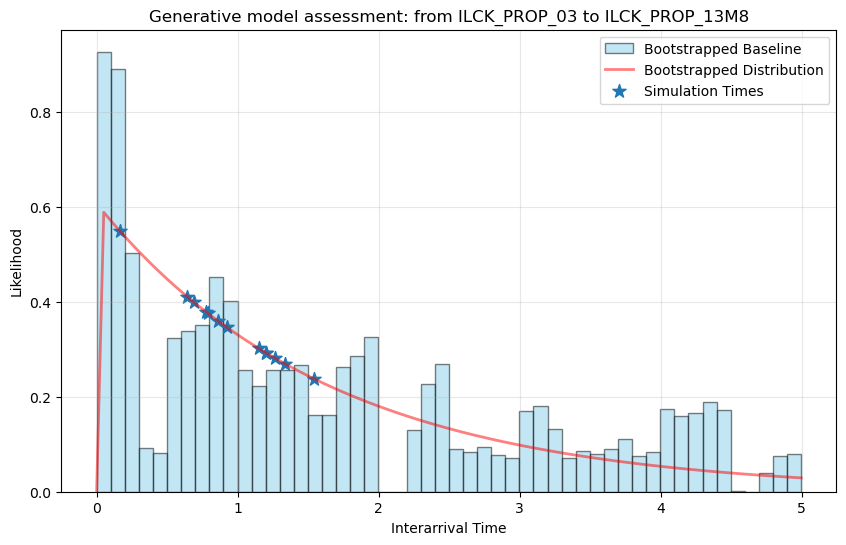

0.5876099946470187


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

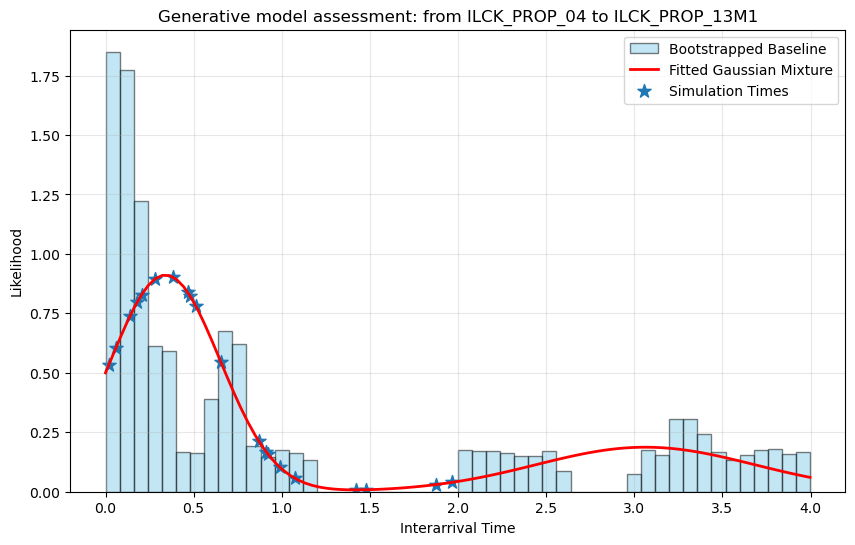

0.4987754723147648


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

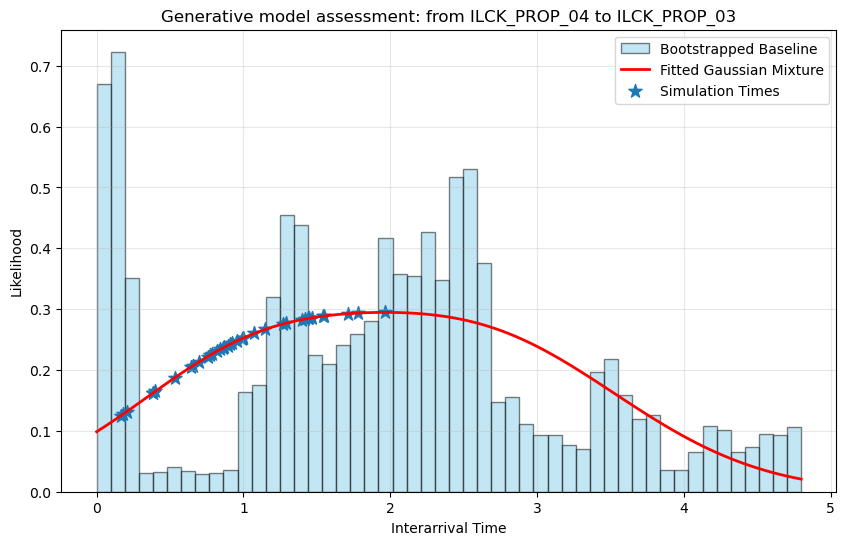

0.8028479334364892


  0%|          | 0/249 [00:00<?, ?it/s]

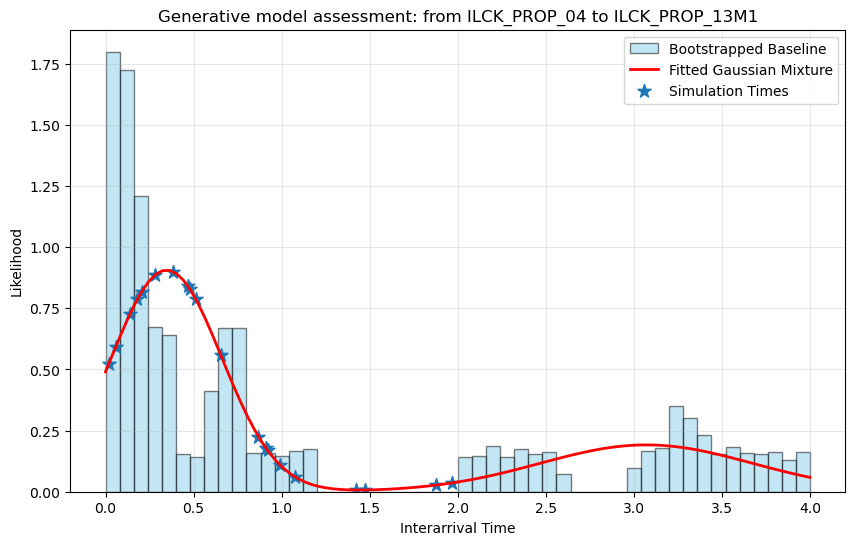

0.5012056795309434


  0%|          | 0/249 [00:00<?, ?it/s]

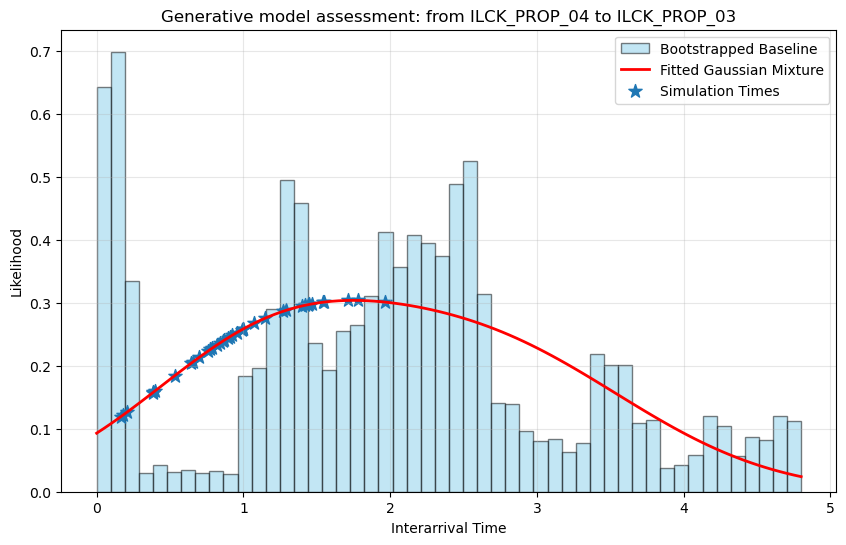

0.7928330805934216


  0%|          | 0/249 [00:00<?, ?it/s]

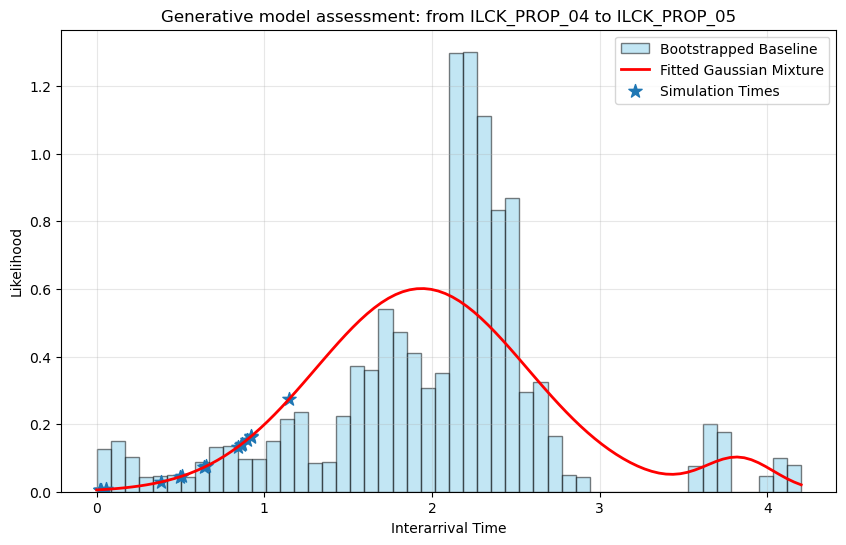

0.1520072379412643


  0%|          | 0/249 [00:00<?, ?it/s]

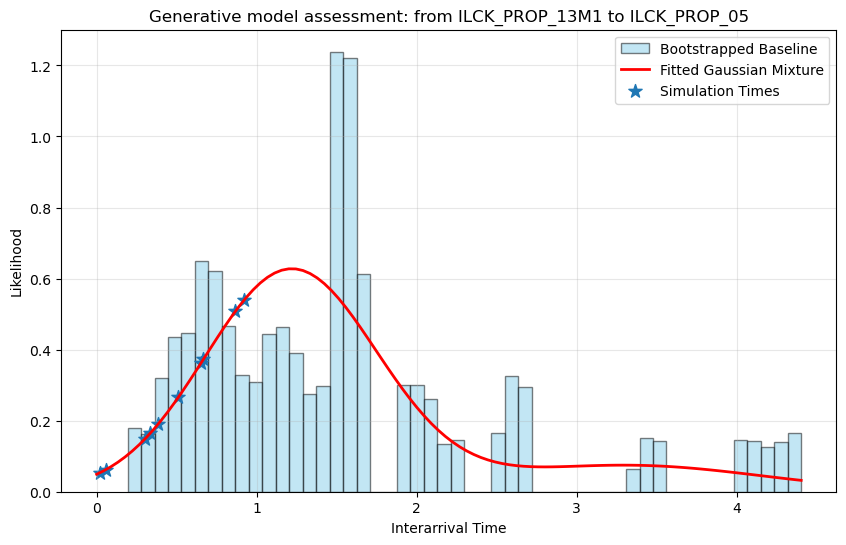

0.4250389940215899


  0%|          | 0/249 [00:00<?, ?it/s]

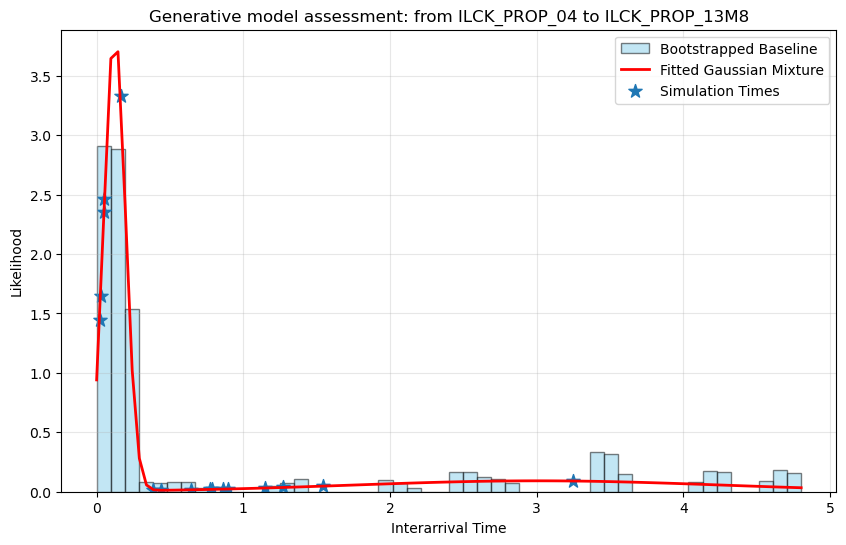

0.19523499608887032


  0%|          | 0/249 [00:00<?, ?it/s]

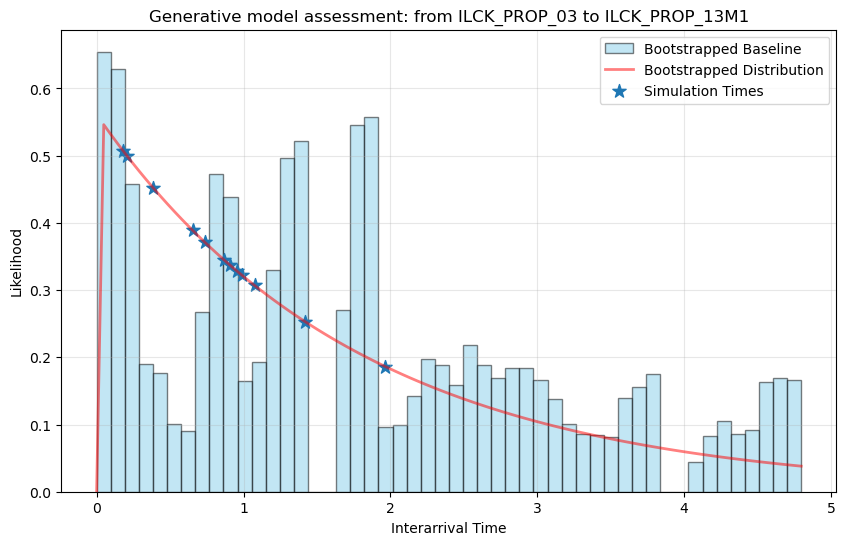

0.6557446243857065


  0%|          | 0/249 [00:00<?, ?it/s]

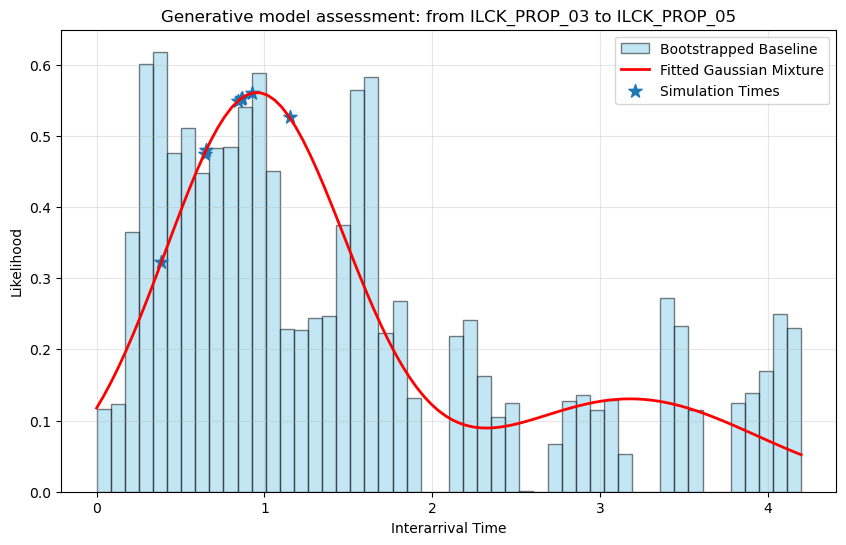

0.8962144606945288


  0%|          | 0/249 [00:00<?, ?it/s]

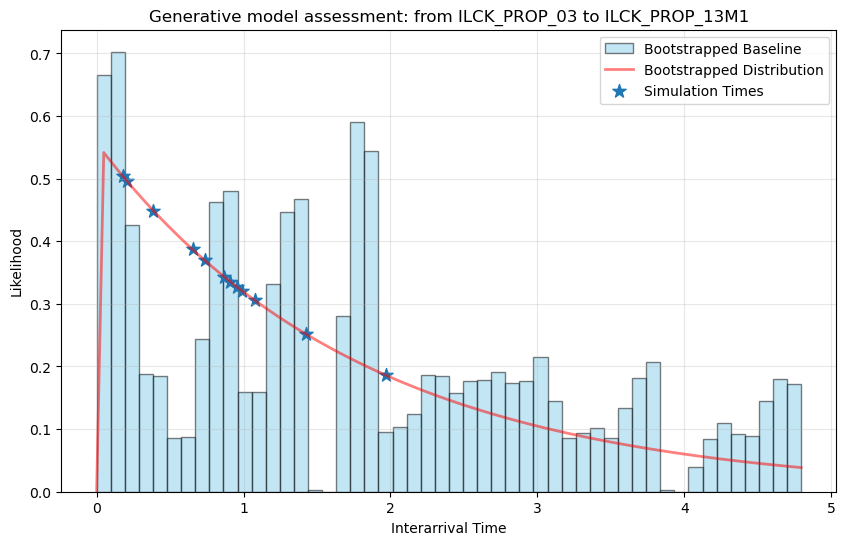

0.657838614699597


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

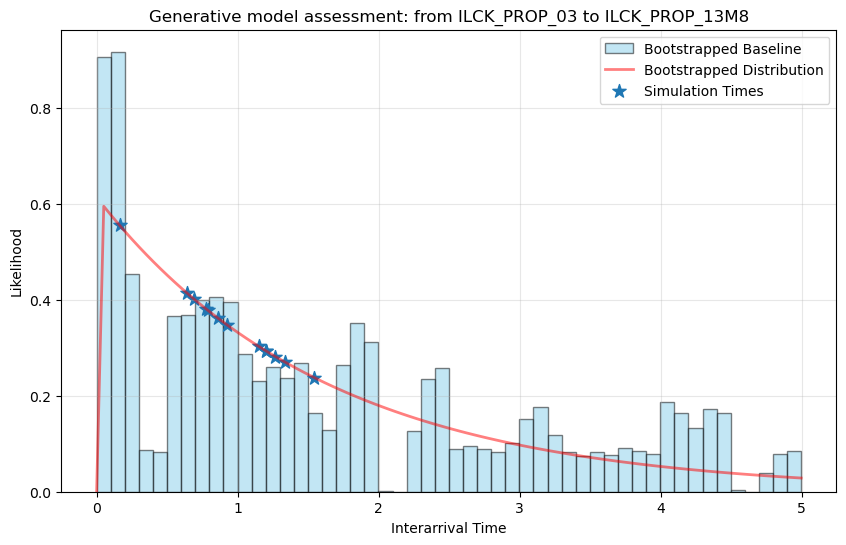

0.5843875720953265


  0%|          | 0/249 [00:00<?, ?it/s]

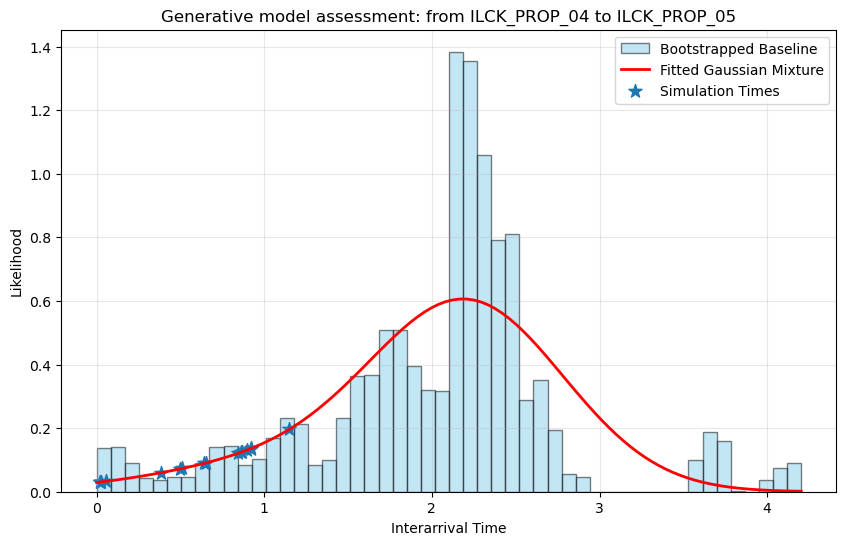

0.15242733673198292


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

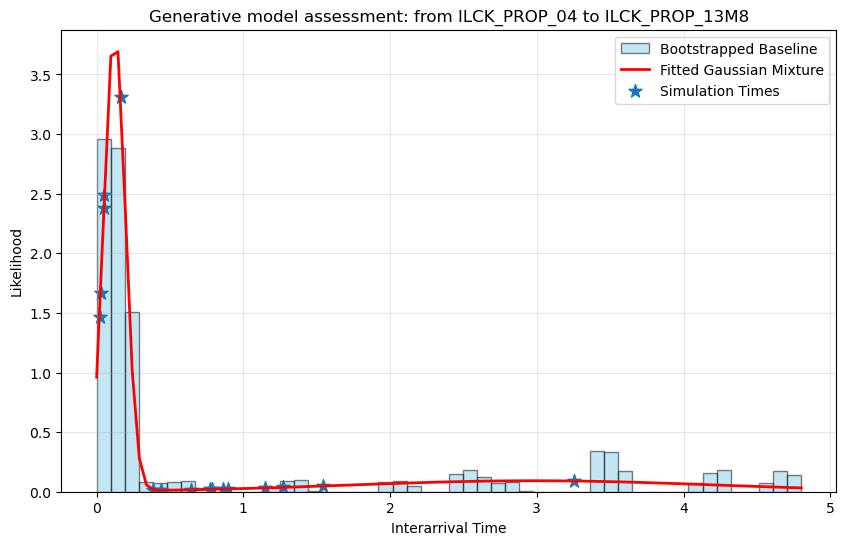

0.19729800843861986


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

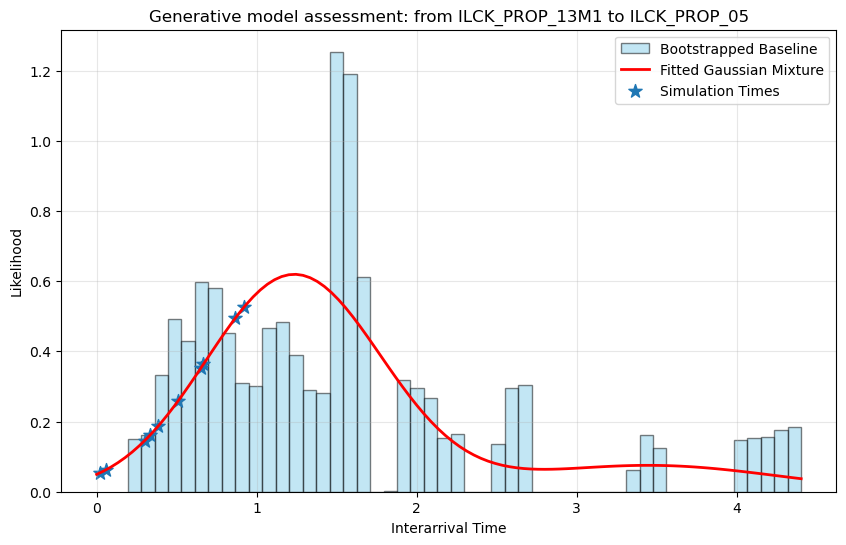

0.4209137386430399


  0%|          | 0/249 [00:00<?, ?it/s]

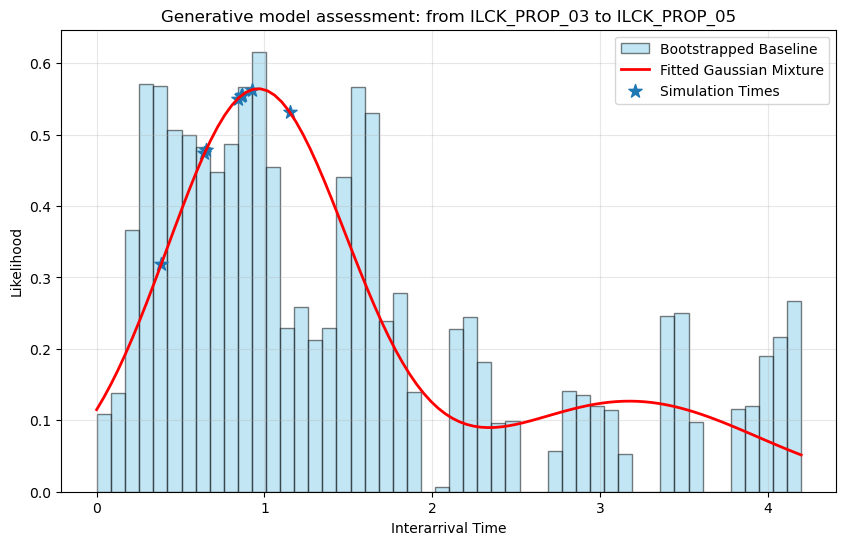

0.8921859856813806


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

Final models score: 0.525785233121534


In [910]:
scores = []

for dependency in popular_dependencies:

    # REAL DATA
    current_df = main_df.loc[main_df['Codice'].apply(
        lambda x: (x in list(dependency)))].copy()
    current_df.sort_values('Timestamp', inplace=True)
    event_change = current_df['Codice'] != current_df['Codice'].shift(1)
    current_df = current_df[event_change].copy()
    current_df['Interarrival_time'] = current_df['Timestamp'].diff(1)
    current_df['Interarrival_time'] = current_df['Interarrival_time'].apply(
        lambda x : x.total_seconds())
    current_df = current_df.loc[current_df['Interarrival_time'] < 5].copy()

    causality1 = current_df.loc[current_df['Codice'] == dependency[0]][[
        'Codice', 'Timestamp', 'Interarrival_time']]
    causality2 = current_df.loc[current_df['Codice'] == dependency[1]][[
        'Codice', 'Timestamp', 'Interarrival_time']]

    # GENERATED DATA
    clusters_to_analyse = []
    for cluster_id in tqdm(cluster_df['Cluster_ID'].unique()):
        codes_for_cluster = cluster_df[cluster_df['Cluster_ID'] == cluster_id]['Codice'].unique()
        permutations = list(itertools.permutations(codes_for_cluster, 2))
        for permutation in permutations:
            if set(permutation) == set(dependency):
                clusters_to_analyse.append(cluster_id)

    clusters_to_analyze = [cluster for _, cluster in cluster_df.loc[cluster_df['Cluster_ID'].apply(
        lambda x: x in clusters_to_analyse)].groupby('Cluster_ID')]

    observed_interarrival_times = []
    for cluster in clusters_to_analyze:
        assert (len(cluster)) > 1
        observed_it = cluster.iloc[0]['Mean_Duration'] / cluster.iloc[0]['N_Events']
        observed_interarrival_times.append(observed_it)

    # ANALYSIS
    if len(causality1) > 30:
        title = f'Generative model assessment: from {dependency[0]} to {dependency[1]}'
        score = validate(
            causality1['Interarrival_time'].values,
            observed_interarrival_times,
            title)
        scores.append(score)
    """
    else:
        print(f'Not enough data to assess causality from {dependency[0]} to {dependency[1]} \n')
    """
    if len(causality2) > 30:
        title = f'Generative model assessment: from {dependency[1]} to {dependency[0]}'
        score = validate(
            causality2['Interarrival_time'].values,
            observed_interarrival_times,
            title)
        scores.append(score)

print(f'Final models score: {np.array(scores).mean()}')

In [911]:
pd.Series(scores).describe()

count    16.000000
mean      0.525785
std       0.255589
min       0.152007
25%       0.365010
50%       0.542797
75%       0.691587
max       0.896214
dtype: float64